# CODE 1921

In [5]:
import pandas as pd
import numpy as np
from glob import glob
import os
import funciones as fun
import variables_nombres as vn
from warnings import simplefilter
import pickle
import joblib

In [6]:
#print(dir(fun))
simplefilter( action = "ignore", category = pd.errors.PerformanceWarning )
#pd.set_option('display.max_rows', 10)
#pd.set_option('display.max_columns', 10)

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import pandas as  pd, numpy as np

In [9]:
# Cargar datos
path = r'..\input\base19_21.csv'
data = pd.read_csv( path )

In [10]:
data = data.dropna( axis = 1 )

In [11]:
data.shape

(39807, 233)

In [12]:
data[ 'pobreza' ].value_counts( normalize = True )

0    0.848318
1    0.151682
Name: pobreza, dtype: float64

In [13]:
data['pobreza'].value_counts()

0    33769
1     6038
Name: pobreza, dtype: int64

In [14]:
data['pobreza'].value_counts()

0    33769
1     6038
Name: pobreza, dtype: int64

## SPLIT VARIABLES

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
dep_var = [ 'pobreza' ]
gasto_all = vn.gasto_variables + vn.gastos_ingresos_vars
no_vars = vn.string_variables + vn.no_predictoras_variables
pred_vars = [ col for col in data.columns if col not in dep_var and col not in gasto_all and col not in no_vars ]

x_train, x_test, y_train, y_test = train_test_split( data[ pred_vars ], 
                                                     data[ 'pobreza' ], 
                                                     test_size = 0.3,
                                                     random_state = 2023 )

## RESAMPLING

### Smote Tomek

In [17]:
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from collections import Counter

In [18]:
os_us = SMOTETomek(random_state=2023, sampling_strategy='all' )
x_train_smote_tomek, y_train_smote_tomek = os_us.fit_resample(x_train, y_train)

print(sorted(Counter(y_train_smote_tomek).items()))

[(0, 23462), (1, 23462)]


### Smote

In [19]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [20]:
os_us = SMOTE(random_state=2023, sampling_strategy='all' )
x_train_smote, y_train_smote = os_us.fit_resample(x_train, y_train)

print(sorted(Counter(y_train_smote).items()))

[(0, 23561), (1, 23561)]


## CHECK DATA

In [21]:
# Check data

check_data = np.zeros( ( 3, 4 ) )
check_data[ 0 ] = [ x_train.shape[ 0 ], x_train.shape[ 1 ], 
                    y_train.value_counts()[ 0 ], y_train.value_counts()[ 1 ] ]

check_data[ 1 ] = [ x_train_smote.shape[ 0 ], x_train_smote.shape[ 1 ], 
                    y_train_smote.value_counts()[ 0 ], y_train_smote.value_counts()[ 1 ] ]

check_data[ 2 ] = [ x_train_smote_tomek.shape[ 0 ], x_train_smote_tomek.shape[ 1 ],
                    y_train_smote_tomek.value_counts()[ 0 ], y_train_smote_tomek.value_counts()[ 1 ] ]

colnames = [ 'observaciones', 'variables', 'Nro. No', 'Nro. Si' ]
rownames = [ 'Original',
             'SMOTE',
             'SOMTE Tomek']

table_check_data = pd.DataFrame( check_data, columns = colnames )
table_check_data.index = rownames
table_check_data

,observaciones,variables,Nro. No,Nro. Si
Original,27864.0,63.0,23561.0,4303.0
SMOTE,47122.0,63.0,23561.0,23561.0
SOMTE Tomek,46924.0,63.0,23462.0,23462.0


## RANDOM FOREST

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [23]:
%%time

# Set the model (Comentado)
rf_model = RandomForestClassifier( random_state = 2023,
                                   n_jobs = -1 )

# Define param grid (Comentado)
rf_param_grid = {
    'n_estimators': [ 500, 1000, 2000 ],
    'max_features': [ 'auto', 'sqrt', 'log2' ]
}

# Grid search (Comentado)
rf_search_o = GridSearchCV( estimator = rf_model,
                            param_grid = rf_param_grid )

rf_search_s = GridSearchCV( estimator = rf_model,
                            param_grid = rf_param_grid )

rf_search_st = GridSearchCV( estimator = rf_model,
                             param_grid = rf_param_grid )

# Fit different models (Comentado)
rf_search_o.fit( x_train, y_train )
rf_search_s.fit( x_train_smote, y_train_smote )
rf_search_st.fit( x_train_smote_tomek, y_train_smote_tomek )

# Print best params and best score (Comentado)
print( f'Original dataset: { rf_search_o.best_params_ }' )
print( f'SMOTE dataset: { rf_search_s.best_params_ }')
print( f'SMOTE Tomek dataset: { rf_search_st.best_params_ }' )

# Select best params (Comentado)
rf_max_features_o = rf_search_o.best_params_[ 'max_features' ]
rf_n_estimators_o = rf_search_o.best_params_[ 'n_estimators' ]

rf_max_features_s = rf_search_s.best_params_[ 'max_features' ]
rf_n_estimators_s = rf_search_s.best_params_[ 'n_estimators' ]

rf_max_features_st = rf_search_st.best_params_[ 'max_features' ]
rf_n_estimators_st = rf_search_st.best_params_[ 'n_estimators' ]

Original dataset: {'max_features': 'auto', 'n_estimators': 2000}
SMOTE dataset: {'max_features': 'auto', 'n_estimators': 2000}
SMOTE Tomek dataset: {'max_features': 'auto', 'n_estimators': 500}
CPU times: total: 21min 51s
Wall time: 34min 52s


In [24]:
### Train the optimal models
rf_optimal_model_o = RandomForestClassifier( max_features = rf_max_features_o, 
                                             n_estimators = rf_n_estimators_o,
                                             random_state = 2023,
                                             n_jobs = -1 )

rf_optimal_model_s = RandomForestClassifier( max_features = rf_max_features_s, 
                                             n_estimators = rf_n_estimators_s,
                                             random_state = 2023,
                                             n_jobs = -1 )

rf_optimal_model_st = RandomForestClassifier( max_features = rf_max_features_st, 
                                              n_estimators = rf_n_estimators_st,
                                              random_state = 2023,
                                              n_jobs = -1 )

rf_optimal_model_o.fit( x_train, y_train )
rf_optimal_model_s.fit( x_train_smote, y_train_smote )
rf_optimal_model_st.fit( x_train_smote_tomek, y_train_smote_tomek )

# Apply over test set
y_rf_pred_class_o = rf_optimal_model_o.predict( x_test )
y_rf_pred_prob_o = rf_optimal_model_o.predict_proba( x_test )[ :, 1 ]

y_rf_pred_class_s = rf_optimal_model_s.predict( x_test )
y_rf_pred_prob_s = rf_optimal_model_s.predict_proba( x_test )[ :, 1 ]

y_rf_pred_class_st = rf_optimal_model_st.predict( x_test )
y_rf_pred_prob_st = rf_optimal_model_st.predict_proba( x_test )[ :, 1 ]

In [25]:
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, f1_score

In [26]:
# Calculating clasiffication report
columns = [ 'no', 'si' ]
rf_report_o = classification_report( y_test, y_rf_pred_class_o, target_names = columns, output_dict = True )
rf_report_s = classification_report( y_test, y_rf_pred_class_s, target_names = columns, output_dict = True )
rf_report_st = classification_report( y_test, y_rf_pred_class_st, target_names = columns, output_dict = True )

# Calculating metrics for the original model
rf_no_precision_o = rf_report_o[ 'no' ][ 'precision' ]
rf_no_recall_o = rf_report_o[ 'no' ][ 'recall' ]
rf_no_f1_score_o = rf_report_o[ 'no' ][ 'f1-score' ]

rf_si_precision_o = rf_report_o[ 'si' ][ 'precision' ]
rf_si_recall_o = rf_report_o[ 'si' ][ 'recall' ]
rf_si_f1_score_o = rf_report_o[ 'si' ][ 'f1-score' ]

accuracy_rf_o = accuracy_score( y_test, y_rf_pred_class_o )
log_loss_rf_o = log_loss( y_test, y_rf_pred_class_o )
roc_auc_rf_o = roc_auc_score( y_test, y_rf_pred_prob_o )
f1_score_rf_o = f1_score( y_test, y_rf_pred_class_o, average = 'binary' )

# Calculating metrics for the SMOTE model
rf_no_precision_s = rf_report_s[ 'no' ][ 'precision' ]
rf_no_recall_s = rf_report_s[ 'no' ][ 'recall' ]
rf_no_f1_score_s = rf_report_s[ 'no' ][ 'f1-score' ]

rf_si_precision_s = rf_report_s[ 'si' ][ 'precision' ]
rf_si_recall_s = rf_report_s[ 'si' ][ 'recall' ]
rf_si_f1_score_s = rf_report_s[ 'si' ][ 'f1-score' ]

accuracy_rf_s = accuracy_score( y_test, y_rf_pred_class_s )
log_loss_rf_s = log_loss( y_test, y_rf_pred_class_s )
roc_auc_rf_s = roc_auc_score( y_test, y_rf_pred_prob_s )
f1_score_rf_s = f1_score( y_test, y_rf_pred_class_s, average = 'binary' )

# Calculating metrics for the SMOTE Tomek model
rf_no_precision_st = rf_report_st[ 'no' ][ 'precision' ]
rf_no_recall_st = rf_report_st[ 'no' ][ 'recall' ]
rf_no_f1_score_st = rf_report_st[ 'no' ][ 'f1-score' ]

rf_si_precision_st = rf_report_st[ 'si' ][ 'precision' ]
rf_si_recall_st = rf_report_st[ 'si' ][ 'recall' ]
rf_si_f1_score_st = rf_report_st[ 'si' ][ 'f1-score' ]

accuracy_rf_st = accuracy_score( y_test, y_rf_pred_class_st )
log_loss_rf_st = log_loss( y_test, y_rf_pred_class_st )
roc_auc_rf_st = roc_auc_score( y_test, y_rf_pred_prob_st )
f1_score_rf_st = f1_score( y_test, y_rf_pred_class_st, average = 'binary' )

## GBOOST

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, matthews_corrcoef

In [28]:
!pip install xgboost

In [29]:
from xgboost import XGBClassifier

In [30]:
%%time

# Set the model (Comentrario) 
xgb_model = XGBClassifier( use_label_encoder = False, 
                           objective = 'binary:logistic', 
                           verbosity = 0,
                           random_state = 2023,
                           n_jobs = -1 )

# Define param grid (Comentrario)
xgb_param_grid = {
    'n_estimators': [ 500, 1000, 2000 ],
    'learning_rate': [0.1, 0.5, 1]
}

# Grid search (Comentrario)
xgb_search_o = GridSearchCV( estimator = xgb_model,
                             param_grid = xgb_param_grid )

xgb_search_s = GridSearchCV( estimator = xgb_model,
                             param_grid = xgb_param_grid )

xgb_search_st = GridSearchCV( estimator = xgb_model,
                              param_grid = xgb_param_grid )

# Fit different models (Comentrario)
xgb_search_o.fit( x_train, y_train )
xgb_search_s.fit( x_train_smote, y_train_smote )
xgb_search_st.fit( x_train_smote_tomek, y_train_smote_tomek )

# Print best params and best scores (Comentrario)
print( f'Original dataset: { xgb_search_o.best_params_ }' )
print( f'SMOTE dataset: { xgb_search_s.best_params_ }' )
print( f'SMOTE Tomek dataset: { xgb_search_st.best_params_ }' )

# Select best params (Comentrario)
xgb_learning_rate_o = xgb_search_o.best_params_[ 'learning_rate' ] 
xgb_n_estimators_o = xgb_search_o.best_params_[ 'n_estimators' ] 

xgb_learning_rate_s = xgb_search_s.best_params_[ 'learning_rate' ] 
xgb_n_estimators_s = xgb_search_s.best_params_[ 'n_estimators' ] 

xgb_learning_rate_st = xgb_search_st.best_params_[ 'learning_rate' ] 
xgb_n_estimators_st = xgb_search_st.best_params_[ 'n_estimators' ]

Original dataset: {'learning_rate': 0.5, 'n_estimators': 2000}
SMOTE dataset: {'learning_rate': 0.5, 'n_estimators': 2000}
SMOTE Tomek dataset: {'learning_rate': 0.5, 'n_estimators': 2000}
CPU times: total: 7h 57min 3s
Wall time: 42min 14s


In [31]:
# Train the optimal model
xgb_optimal_model_o = XGBClassifier( objective = 'binary:logistic', 
                                     verbosity = 0,
                                     learning_rate = xgb_learning_rate_o, 
                                     n_estimators = xgb_n_estimators_o,
                                     random_state = 2023,
                                     n_jobs = -1 )

xgb_optimal_model_s = XGBClassifier( objective = 'binary:logistic', 
                                     verbosity = 0,
                                     learning_rate = xgb_learning_rate_o, 
                                     n_estimators = xgb_n_estimators_o,
                                     random_state = 2023,
                                     n_jobs = -1 )

xgb_optimal_model_st = XGBClassifier( objective = 'binary:logistic', 
                                      verbosity = 0,
                                      learning_rate = xgb_learning_rate_o, 
                                      n_estimators = xgb_n_estimators_o,
                                      random_state = 2023,
                                      n_jobs = -1 )

xgb_optimal_model_o.fit( x_train, y_train )
xgb_optimal_model_s.fit( x_train_smote, y_train_smote )
xgb_optimal_model_st.fit( x_train_smote_tomek, y_train_smote_tomek )

# Apply over test set
y_xgb_pred_class_o = xgb_optimal_model_o.predict( x_test )
y_xgb_pred_prob_o = xgb_optimal_model_o.predict_proba( x_test )[ :, 1 ]

y_xgb_pred_class_s = xgb_optimal_model_s.predict( x_test )
y_xgb_pred_prob_s = xgb_optimal_model_s.predict_proba( x_test )[ :, 1 ]

y_xgb_pred_class_st = xgb_optimal_model_st.predict( x_test )
y_xgb_pred_prob_st = xgb_optimal_model_st.predict_proba( x_test )[ :, 1 ]

In [32]:
# Calculating clasiffication report
columns = [ 'no', 'si' ]
xgb_report_o = classification_report( y_test, 
                                      y_xgb_pred_class_o, 
                                      target_names = columns, 
                                      output_dict = True)

xgb_report_s = classification_report( y_test, 
                                      y_xgb_pred_class_s, 
                                      target_names = columns, 
                                      output_dict = True)

xgb_report_st = classification_report( y_test, 
                                       y_xgb_pred_class_st, 
                                       target_names = columns, 
                                       output_dict = True)

# Calculating metrics for the original model
xgb_no_precision_o = xgb_report_o[ 'no' ][ 'precision' ]
xgb_no_recall_o = xgb_report_o[ 'no' ][ 'recall' ]
xgb_no_f1_score_o = xgb_report_o[ 'no' ][ 'f1-score' ]

xgb_si_precision_o = xgb_report_o[ 'si' ][ 'precision' ]
xgb_si_recall_o = xgb_report_o[ 'si' ][ 'recall' ]
xgb_si_f1_score_o = xgb_report_o[ 'si' ][ 'f1-score' ]

accuracy_xgb_o = accuracy_score( y_test, y_xgb_pred_class_o )
log_loss_xgb_o = log_loss( y_test, y_xgb_pred_class_o )
roc_auc_xgb_o = roc_auc_score( y_test, y_xgb_pred_prob_o )
f1_score_xgb_o = f1_score( y_test, y_xgb_pred_class_o, average = 'binary' )

# Calculating metrics for the SMOTE model
xgb_no_precision_s = xgb_report_s[ 'no' ][ 'precision' ]
xgb_no_recall_s = xgb_report_s[ 'no' ][ 'recall' ]
xgb_no_f1_score_s = xgb_report_s[ 'no' ][ 'f1-score' ]

xgb_si_precision_s = xgb_report_s[ 'si' ][ 'precision' ]
xgb_si_recall_s = xgb_report_s[ 'si' ][ 'recall' ]
xgb_si_f1_score_s = xgb_report_s[ 'si' ][ 'f1-score' ]

accuracy_xgb_s = accuracy_score( y_test, y_xgb_pred_class_s )
log_loss_xgb_s = log_loss( y_test, y_xgb_pred_class_s )
roc_auc_xgb_s = roc_auc_score( y_test, y_xgb_pred_prob_s )
f1_score_xgb_s = f1_score( y_test, y_xgb_pred_class_s, average = 'binary' )

# Calculating metrics for the SMOTE Tomek model
xgb_no_precision_st = xgb_report_st[ 'no' ][ 'precision' ]
xgb_no_recall_st = xgb_report_st[ 'no' ][ 'recall' ]
xgb_no_f1_score_st = xgb_report_st[ 'no' ][ 'f1-score' ]

xgb_si_precision_st = xgb_report_st[ 'si' ][ 'precision' ]
xgb_si_recall_st = xgb_report_st[ 'si' ][ 'recall' ]
xgb_si_f1_score_st = xgb_report_st[ 'si' ][ 'f1-score' ]

accuracy_xgb_st = accuracy_score( y_test, y_xgb_pred_class_st )
log_loss_xgb_st = log_loss( y_test, y_xgb_pred_class_st )
roc_auc_xgb_st = roc_auc_score( y_test, y_xgb_pred_prob_st )
f1_score_xgb_st = f1_score( y_test, y_xgb_pred_class_st, average = 'binary' )

## RESULTADOS

In [33]:
# Calculate Matthews Correlation Coefficient
from sklearn.metrics import matthews_corrcoef

mcc_rf_o = matthews_corrcoef( y_test, y_rf_pred_class_o )
mcc_rf_s = matthews_corrcoef( y_test, y_rf_pred_class_s )
mcc_rf_st = matthews_corrcoef( y_test, y_rf_pred_class_st )

# Calculate Matthews Correlation Coefficient con GBoost
mcc_xgb_o = matthews_corrcoef( y_test, y_xgb_pred_class_o )
mcc_xgb_s = matthews_corrcoef( y_test, y_xgb_pred_class_s )
mcc_xgb_st = matthews_corrcoef( y_test, y_xgb_pred_class_st )

In [34]:
## con gboost

table = np.zeros( ( 6, 10 ) )

table[ 0 ] = [ accuracy_rf_o, roc_auc_rf_o, f1_score_rf_o, mcc_rf_o, rf_no_precision_o, rf_no_recall_o, 
               rf_no_f1_score_o, rf_si_precision_o, rf_si_recall_o, rf_si_f1_score_o ]

table[ 1 ] = [ accuracy_rf_s, roc_auc_rf_s, f1_score_rf_s, mcc_rf_s, rf_no_precision_s, rf_no_recall_s, 
               rf_no_f1_score_s, rf_si_precision_s, rf_si_recall_s, rf_si_f1_score_s ]

table[ 2 ] = [ accuracy_rf_st, roc_auc_rf_st, f1_score_rf_st, mcc_rf_st, rf_no_precision_st, rf_no_recall_st, 
               rf_no_f1_score_st, rf_si_precision_st, rf_si_recall_st, rf_si_f1_score_st ]

table[ 3 ] = [ accuracy_xgb_o, roc_auc_xgb_o, f1_score_xgb_o, mcc_xgb_o, xgb_no_precision_o, xgb_no_recall_o, 
               xgb_no_f1_score_o, xgb_si_precision_o, xgb_si_recall_o, xgb_si_f1_score_o ]

table[ 4 ] = [ accuracy_xgb_s, roc_auc_xgb_s, f1_score_xgb_s, mcc_xgb_s, xgb_no_precision_s, xgb_no_recall_s, 
               xgb_no_f1_score_s, xgb_si_precision_s, xgb_si_recall_s, xgb_si_f1_score_s ]

table[ 5 ] = [ accuracy_xgb_st, roc_auc_xgb_st, f1_score_xgb_st, mcc_xgb_st, xgb_no_precision_st, xgb_no_recall_st, 
               xgb_no_f1_score_st, xgb_si_precision_st, xgb_si_recall_st, xgb_si_f1_score_st ]

colnames_table = [ "Overall_Accuracy", "Roc_Auc", "Global_F1_Score", "Matthews_Corr_Coef", "No_Precision", 
                   "No_Recall", "No_F1_Score", "Si_Precision", "Si_Recall", "Si_F1_Score" ]
                  
rownames_table = [ "O. Random Forest",                   
                   "S. Random Forest", 
                   "ST. Random Forest",
                   "O. Boosted Trees",
                   "S. Boosted Trees",
                 "ST. Boosted Trees"]                  

table_pandas = pd.DataFrame( table, columns = colnames_table )
table_pandas.index = rownames_table

table_pandas = table_pandas.round( 3 )
table_pandas

,Overall_Accuracy,Roc_Auc,Global_F1_Score,Matthews_Corr_Coef,No_Precision,No_Recall,No_F1_Score,Si_Precision,Si_Recall,Si_F1_Score
O. Random Forest,0.942,0.958,0.770,0.749,0.946,0.989,0.967,0.909,0.668,0.770
S. Random Forest,0.922,0.945,0.745,0.700,0.963,0.946,0.954,0.710,0.783,0.745
ST. Random Forest,0.919,0.942,0.737,0.690,0.961,0.943,0.952,0.700,0.777,0.737
O. Boosted Trees,0.964,0.961,0.873,0.853,0.975,0.984,0.979,0.899,0.849,0.873
S. Boosted Trees,0.950,0.958,0.832,0.803,0.976,0.966,0.971,0.809,0.858,0.832
ST. Boosted Trees,0.949,0.956,0.828,0.798,0.975,0.965,0.970,0.804,0.854,0.828


# SAVE MODELS

In [35]:
joblib.dump( rf_optimal_model_o, r'..\extra\ejecucion_1\models\rf_o_1921.joblib' )
joblib.dump( rf_optimal_model_s, r'..\extra\ejecucion_1\models\rf_s_1921.joblib' )
joblib.dump( rf_optimal_model_st, r'..\extra\ejecucion_1\models\rf_st_1921.joblib' )

joblib.dump( xgb_optimal_model_o, r'..\extra\ejecucion_1\models\xgb_o_1921.joblib' )
joblib.dump( xgb_optimal_model_s, r'..\extra\ejecucion_1\models\xgb_s_1921.joblib' )
joblib.dump( xgb_optimal_model_st, r'..\extra\ejecucion_1\models\xgb_st_1921.joblib' )

['..\\extra\\ejecucion_1\\models\\xgb_st_1921.joblib']

# GRID SEARCH RESULTS

In [36]:
# Store Grid Search Results for Random Forest
results_gs_rf_o = pd.DataFrame( rf_search_o.cv_results_ )
results_gs_rf_s = pd.DataFrame( rf_search_s.cv_results_ )
results_gs_rf_st = pd.DataFrame( rf_search_st.cv_results_ )

# Store Grid Search Results for Boosted Trees
results_gs_xgb_o = pd.DataFrame( xgb_search_o.cv_results_ )
results_gs_xgb_s = pd.DataFrame( xgb_search_s.cv_results_ )
results_gs_xgb_st = pd.DataFrame( xgb_search_st.cv_results_ )

In [37]:
# Save Grid Search Results for Random Forest
results_gs_rf_o.to_excel( r'..\results\ejecucion_1\gridsearch_results\1921_results_gs_rf_o.xlsx' )
results_gs_rf_s.to_excel( r'..\results\ejecucion_1\gridsearch_results\1921_results_gs_rf_s.xlsx' )
results_gs_rf_st.to_excel( r'..\results\ejecucion_1\gridsearch_results\1921_results_gs_rf_st.xlsx' )

# Save Grid Search Results for Boosted Trees
results_gs_xgb_o.to_excel( r'..\results\ejecucion_1\gridsearch_results\1921_results_gs_xgb_o.xlsx' )
results_gs_xgb_s.to_excel( r'..\results\ejecucion_1\gridsearch_results\1921_results_gs_xgb_s.xlsx' )
results_gs_xgb_st.to_excel( r'..\results\ejecucion_1\gridsearch_results\1921_results_gs_xgb_st.xlsx' )

# FEATURE MAP

In [38]:
# Random Forest (Original) 
fp_randomforest_o = pd.Series( rf_optimal_model_o.feature_importances_, index = pred_vars ).\
                    sort_values( ascending = False )

fp_randomforest_o = pd.DataFrame( fp_randomforest_o.head( 50 ) ).\
                                  reset_index().\
                                  rename( columns = { 'index': 'vars', 0: 'score' } )

In [39]:
# Random Forest (SMOTE)
fp_randomforest_s = pd.Series( rf_optimal_model_s.feature_importances_, index = pred_vars ).\
                    sort_values( ascending = False )

fp_randomforest_s = pd.DataFrame( fp_randomforest_s.head( 50 ) ).\
                                  reset_index().\
                                  rename( columns = { 'index': 'vars', 0: 'score' } )

In [40]:
# Random Forest (SMOTE Tomek)
fp_randomforest_st = pd.Series( rf_optimal_model_st.feature_importances_, index = pred_vars ).\
                     sort_values( ascending = False )

fp_randomforest_st = pd.DataFrame( fp_randomforest_st.head( 50 ) ).\
                                   reset_index().\
                                   rename( columns = { 'index': 'vars', 0: 'score' } )

In [41]:
# Boosted Trees (Original)
fp_xgboost_o = pd.Series( xgb_optimal_model_o.feature_importances_, index = pred_vars ).\
           sort_values( ascending = False )

fp_xgboost_o = pd.DataFrame( fp_xgboost_o.head( 50 ) ).\
                             reset_index().\
                             rename( columns = { 'index': 'vars', 0: 'score' } )

In [42]:
# Boosted Trees (SMOTE)
fp_xgboost_s = pd.Series( xgb_optimal_model_s.feature_importances_, index = pred_vars ).\
               sort_values( ascending = False )

fp_xgboost_s = pd.DataFrame( fp_xgboost_s.head( 50 ) ).\
                             reset_index().\
                             rename( columns = { 'index': 'vars', 0: 'score' } )

In [43]:
# Boosted Trees (SMOTE Tomek)
fp_xgboost_st = pd.Series( xgb_optimal_model_st.feature_importances_, index = pred_vars ).\
                sort_values( ascending = False )

fp_xgboost_st = pd.DataFrame( fp_xgboost_st.head( 50 ) ).\
                              reset_index().\
                              rename( columns = { 'index': 'vars', 0: 'score' } )

In [44]:
# Tabla general
table_pandas.to_excel( r'..\results\ejecucion_1\results\base_1921_results.xlsx' )

In [45]:
# Variables Random Forest

fp_randomforest_o.to_excel( r'..\results\ejecucion_1\results\base_1921_rf_o.xlsx' )
fp_randomforest_s.to_excel( r'..\results\ejecucion_1\results\base_1921_rf_s.xlsx' )
fp_randomforest_st.to_excel( r'..\results\ejecucion_1\results\base_1921_rf_st.xlsx' )

In [46]:
# Variables Boosted Trees

fp_xgboost_o.to_excel( r'..\results\ejecucion_1\results\base_1921_xgb_o.xlsx' )
fp_xgboost_s.to_excel( r'..\results\ejecucion_1\results\base_1921_xgb_s.xlsx' )
fp_xgboost_st.to_excel( r'..\results\ejecucion_1\results\base_1921_xgb_st.xlsx' )

## ROC CURVES

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import matplotlib.pyplot as plt

In [48]:
from sklearn import metrics
import matplotlib.pyplot as plt

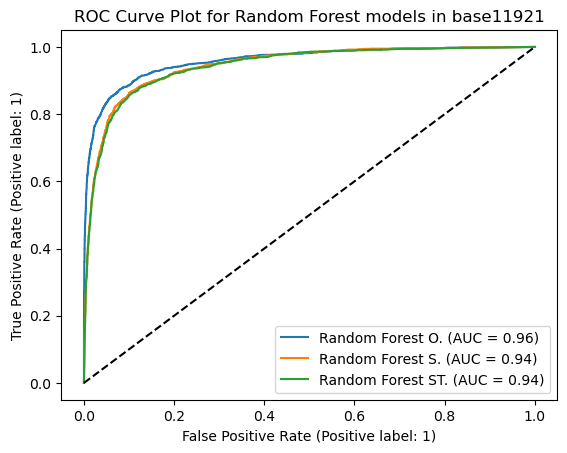

In [49]:
## RANDOM FOREST

from sklearn.metrics import RocCurveDisplay

# Crear una figura y un eje para el plot
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator( rf_optimal_model_o, x_test, y_test, ax = ax, name = 'Random Forest O.' )
RocCurveDisplay.from_estimator( rf_optimal_model_s, x_test, y_test, ax = ax, name = 'Random Forest S.' )
RocCurveDisplay.from_estimator( rf_optimal_model_st, x_test, y_test, ax = ax, name = 'Random Forest ST.' )

# Trazar la línea base
plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

# Configurar plot
ax.set_title( 'ROC Curve Plot for Random Forest models in base11921' )
ax.legend( loc = 'lower right' )

# Guardar plot como JPG
plt.savefig( r'..\results\plots\roc_curve_rf_1921.jpg', dpi = 300, bbox_inches = 'tight' )

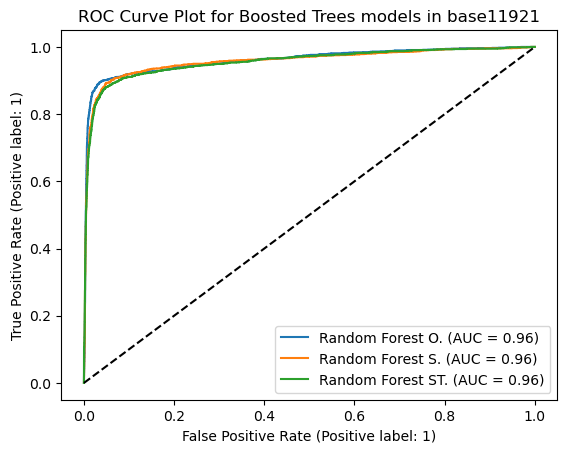

In [50]:
## Boosted trees

from sklearn.metrics import RocCurveDisplay

# Crear una figura y un eje para el plot
fig, ax = plt.subplots()

RocCurveDisplay.from_estimator( xgb_optimal_model_o, x_test, y_test, ax = ax, name = 'Random Forest O.' )
RocCurveDisplay.from_estimator( xgb_optimal_model_s, x_test, y_test, ax = ax, name = 'Random Forest S.' )
RocCurveDisplay.from_estimator( xgb_optimal_model_st, x_test, y_test, ax = ax, name = 'Random Forest ST.' )

# Trazar la línea base
plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

# Configurar plot
ax.set_title( 'ROC Curve Plot for Boosted Trees models in base11921' )
ax.legend( loc = 'lower right' )

# Guardar plot como JPG
plt.savefig( r'..\results\plots\roc_curve_xgb_1921.jpg', dpi = 300, bbox_inches = 'tight' )